# Analyzing NYC's Stormwater Flood Map - Extreme Flood Scenario
## Objective: Spatial Joins and Summary Statistics per Neighborhood Tabulation Area (NTA)

Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,seaborn,matplotlib,geopandas

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.22.4
pandas    : 1.4.2
seaborn   : 0.11.2
matplotlib: 3.5.2
geopandas : 0.9.0



![data-description](images/data-description.png)

Screenshot of data description.  
Source: https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Extreme-Flood-with-2080-S/w8eg-8ha6

In [3]:
# list files in data directory
%ls data/

buildings-hazard.csv      hourly-precipitation.csv  stormwater-data-source/
daily-precipitation.csv   nta-hazard.csv            stormwater-data.zip


In [4]:
# read in data
gdf = gpd.read_file('data/stormwater-data.zip')

# sanity checks
print('shape: {}'.format(gdf.shape))
print('crs: {}'.format(gdf.crs))

# preview data
gdf.head()

shape: (12036, 5)
crs: epsg:2263


,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry
0,1,Nuisance Flooding,1695.857677,27852.535494,"POLYGON Z ((916393.149 121765.469 0.000, 91640..."
1,1,Nuisance Flooding,1532.269198,18338.901687,"POLYGON Z ((917251.502 121381.664 0.000, 91725..."
2,1,Nuisance Flooding,2327.963831,32127.388341,"POLYGON Z ((916251.188 121441.271 0.000, 91625..."
3,1,Nuisance Flooding,3830.095703,48711.665246,"POLYGON Z ((917377.109 122108.195 0.000, 91739..."
4,1,Nuisance Flooding,4600.270710,65321.650657,"POLYGON Z ((918159.499 121451.773 0.000, 91814..."


In [5]:
# summary statistics of flood polygons
(gdf
 .groupby(by='flood_classification')[['flood_classification']]
 .count()
 .rename(columns={'flood_classification':'count_polygons'})
)

,count_polygons
flood_classification,
Deep and Contiguous Flooding,3703
Future High Tides 2080,407
Nuisance Flooding,7926


In [6]:
# summary statistics of flood polygons
acres_conversion = 43560

(gdf
 .groupby(by='flood_classification')[['Shape_Area']]
 .sum()
 .div(acres_conversion)
 .round(0)
 .astype(int)
 .rename(columns={'Shape_Area':'shape_area_acres'})
 .reset_index()
)

,flood_classification,shape_area_acres
0,Deep and Contiguous Flooding,6093
1,Future High Tides 2080,7883
2,Nuisance Flooding,6887


# NYC Boroughs

In [7]:
# importing borough boundaries
path = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
borough_gdf = gpd.read_file(path)

# preview data
print('shape of data: {}'.format(borough_gdf.shape))
borough_gdf.head()

shape of data: (5, 5)


,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623621e+09,325917.353950,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2.0,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,4.0,Queens,3.041419e+09,888199.730955,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
3,1.0,Manhattan,6.365205e+08,357713.308660,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,3.0,Brooklyn,1.934138e+09,728148.532410,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."


In [8]:
# examine crs
borough_gdf.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [9]:
# transform crs
borough_gdf = borough_gdf.to_crs(2263)

borough_gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'NYC Boroughs')

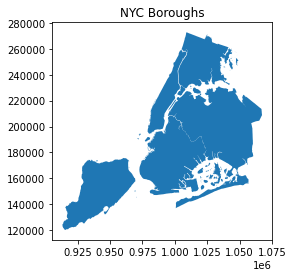

In [10]:
# quick sanity plot of boroughs
borough_gdf.plot()
plt.title('NYC Boroughs')

# Exploratory Maps by Flood Classification

In [11]:
# preview data
gdf.head()

,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry
0,1,Nuisance Flooding,1695.857677,27852.535494,"POLYGON Z ((916393.149 121765.469 0.000, 91640..."
1,1,Nuisance Flooding,1532.269198,18338.901687,"POLYGON Z ((917251.502 121381.664 0.000, 91725..."
2,1,Nuisance Flooding,2327.963831,32127.388341,"POLYGON Z ((916251.188 121441.271 0.000, 91625..."
3,1,Nuisance Flooding,3830.095703,48711.665246,"POLYGON Z ((917377.109 122108.195 0.000, 91739..."
4,1,Nuisance Flooding,4600.270710,65321.650657,"POLYGON Z ((918159.499 121451.773 0.000, 91814..."


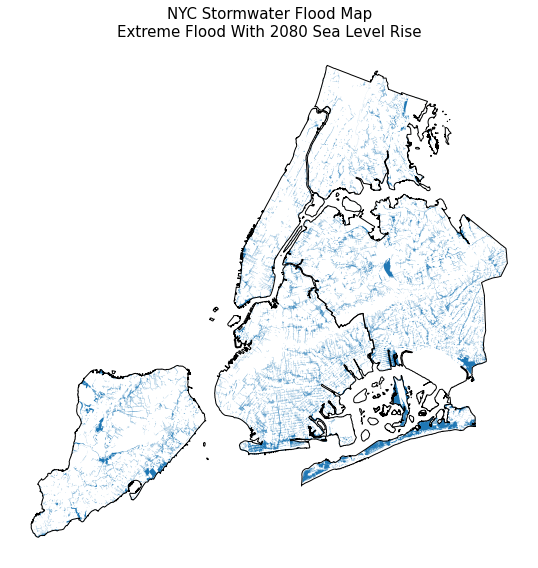

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(ax=ax)

borough_gdf.plot(
    ax=ax,
    facecolor='none', 
    edgecolor='black', 
    zorder=1
)

plt.title('NYC Stormwater Flood Map\nExtreme Flood With 2080 Sea Level Rise', fontsize=15)
plt.axis('off')
plt.tight_layout()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


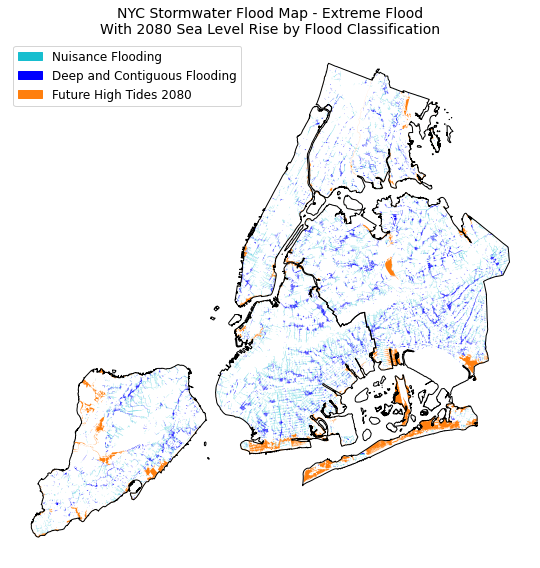

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

patches = []
colors = ['tab:cyan', 'blue', 'tab:orange']
classifications = gdf['flood_classification'].unique()

for label, color in zip(classifications, colors):
    
    (gdf
     .loc[gdf['flood_classification'].isin([label])]
     .plot(color=color, ax=ax)
    )
    
    patches.append(mpatches.Patch(color=color, label=label))
    
borough_gdf.plot(
    ax=ax, 
    facecolor='none', 
    edgecolor='black', 
    zorder=1
)

plt.legend(
    title='', 
    handles=patches, 
    fontsize='12', 
    loc=2
) 

title = 'NYC Stormwater Flood Map - Extreme Flood\nWith 2080 Sea Level Rise by Flood Classification'
plt.title(title, fontsize=14)
plt.axis('off')
plt.tight_layout()

# save as repo cover photo
plt.savefig('figures/cover-map.png', dpi=250, bbox_inches='tight')

Let's map by each flood classification individually.

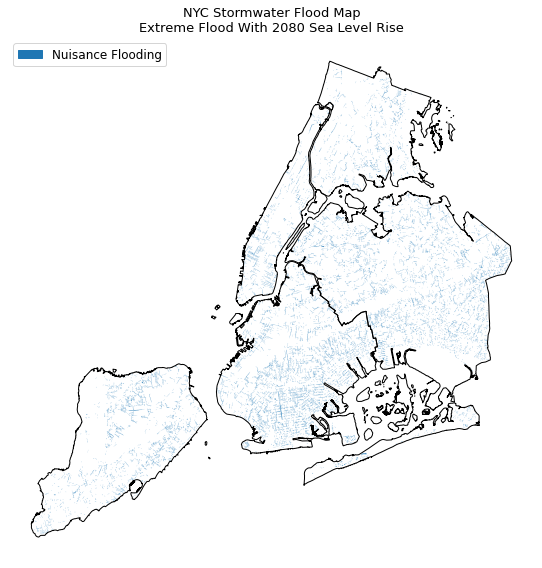

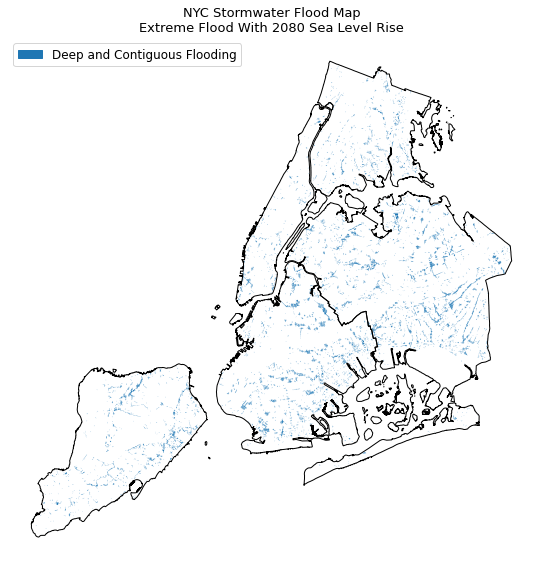

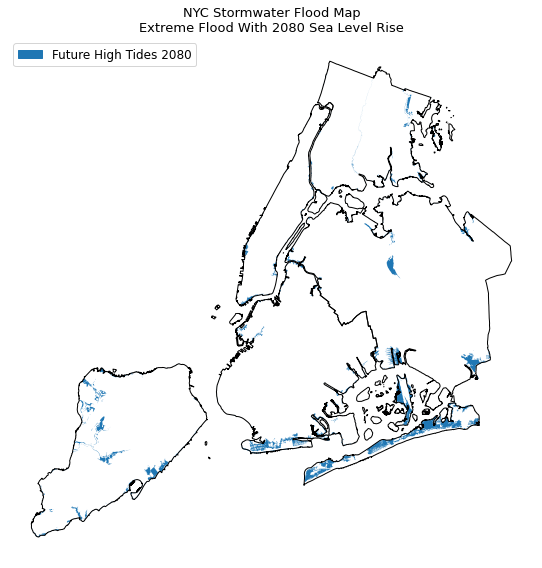

In [14]:
classifications = gdf['flood_classification'].unique()
color = 'C0'

# map each flood classification individually
for label in classifications:
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    (gdf
     .loc[gdf['flood_classification'].isin([label])]
     .plot(color=color, ax=ax, legend=True)
    )
    
    patches = [mpatches.Patch(color=color, label=label)]
    
    borough_gdf.plot(
        ax=ax,
        facecolor='none',
        edgecolor='black',
        zorder=1
    )
    
    plt.legend(
        title='', 
        handles=patches, 
        fontsize='12', 
        loc=2
    ) 
    
    title = 'NYC Stormwater Flood Map\nExtreme Flood With 2080 Sea Level Rise'
    plt.title(title, fontsize=13)
    plt.axis('off')
    plt.tight_layout()

# Clip Flood Polygons by Borough
Let's clip stormwater flood hazards to boroughs.

In [15]:
%%time

boros = borough_gdf['boro_name'].unique()
lst = []

for boro in boros:
    
    mask = borough_gdf.loc[borough_gdf['boro_name'] == boro]
    # add 0 buffer to flood polygon geometry to use clip method
    gdf['geometry'] = gdf['geometry'].buffer(0)
    
    # clip flood polygon against borough geometry
    clipped = gpd.clip(gdf, mask)
    clipped['boro'] = boro
    lst.append(clipped)

# concat all clipped flood polygons to return one geodataframe 
clipped_gdf = pd.concat(lst).reset_index(drop=True)
clipped_gdf['Shape_Area'] = clipped_gdf.area
clipped_gdf['Shape_Length'] = clipped_gdf.length

# preview data
print('shape of data: {}'.format(clipped_gdf.shape))
clipped_gdf.head()

shape of data: (12076, 6)
CPU times: user 1min 30s, sys: 551 ms, total: 1min 31s
Wall time: 1min 31s


,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry,boro
0,1,Nuisance Flooding,1695.857677,27852.535494,"POLYGON Z ((916405.124 121753.026 0.000, 91641...",Staten Island
1,1,Nuisance Flooding,1532.269198,18338.901687,"POLYGON Z ((917251.502 121394.523 0.000, 91723...",Staten Island
2,1,Nuisance Flooding,2327.963831,32127.388341,"POLYGON Z ((916254.418 121431.775 0.000, 91625...",Staten Island
3,1,Nuisance Flooding,3830.095703,48711.665246,"POLYGON Z ((917395.081 122108.181 0.000, 91741...",Staten Island
4,1,Nuisance Flooding,4600.270710,65321.650657,"POLYGON Z ((917905.522 121601.079 0.000, 91791...",Staten Island


## Examine Clipped Deep and Continuous Flooding by Borough

Also useful as a brief QA.

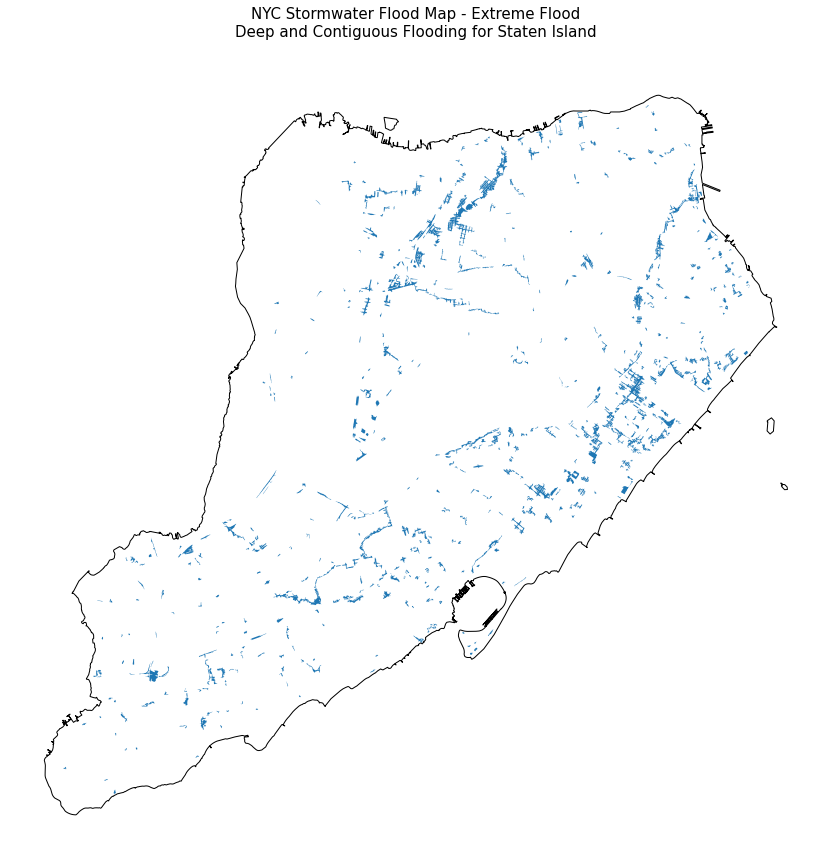

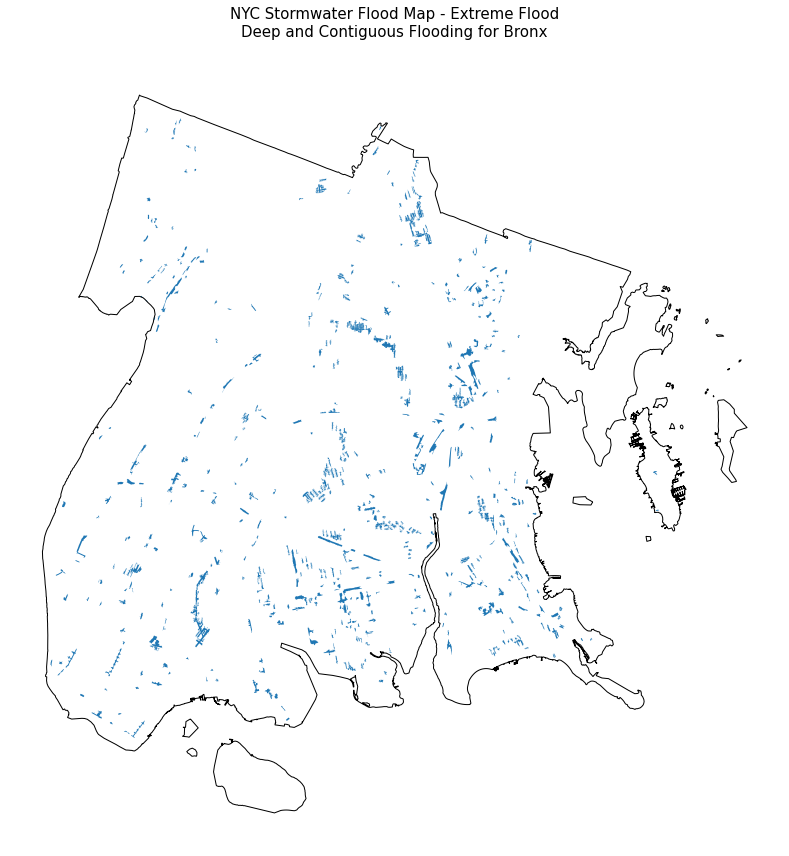

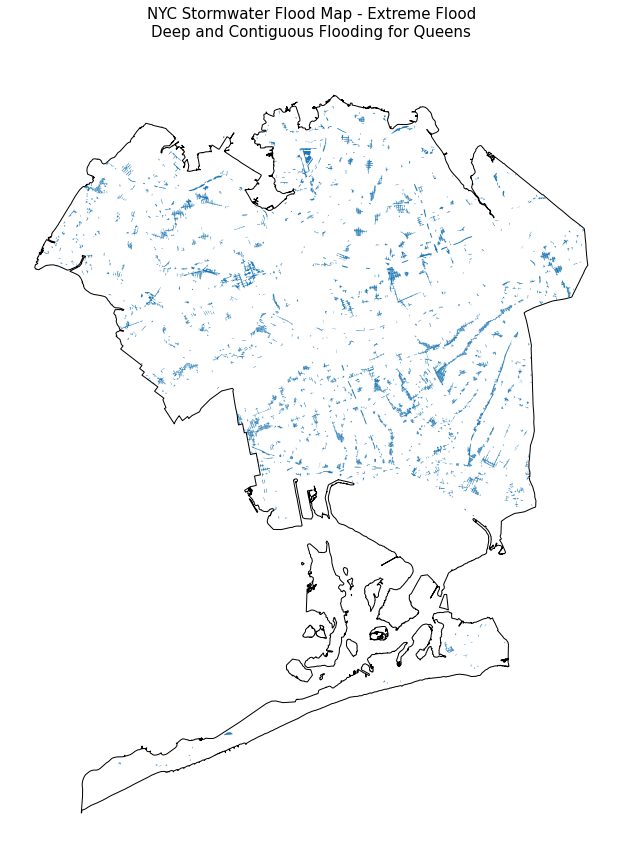

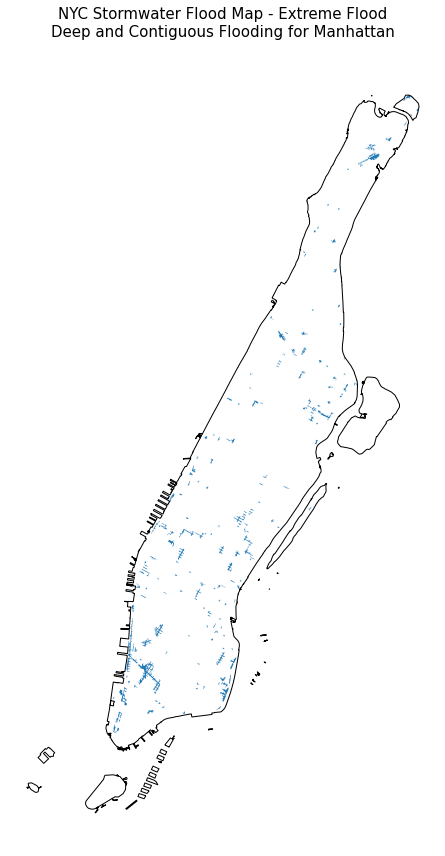

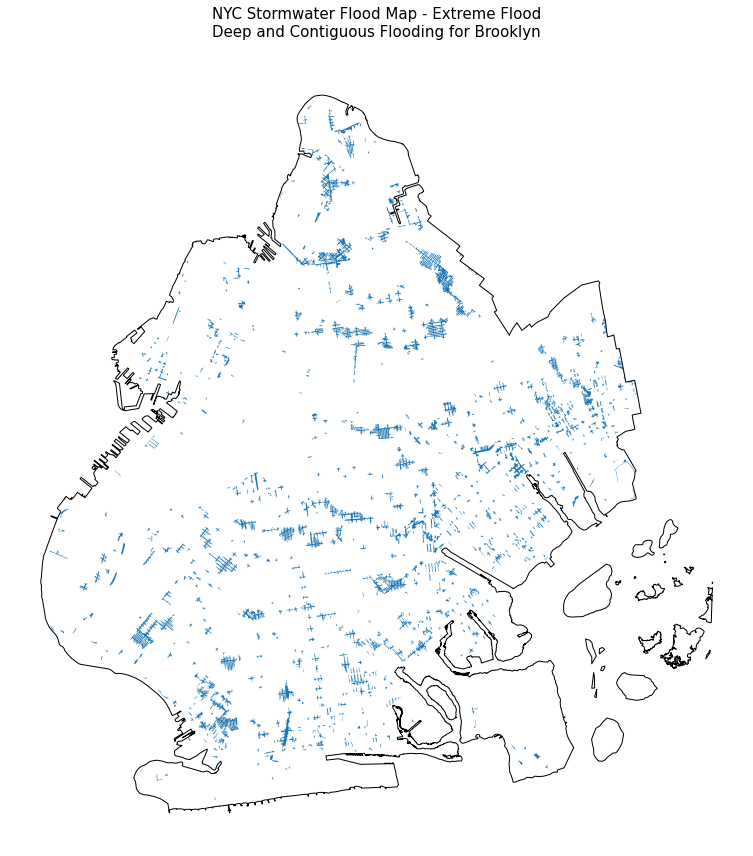

In [16]:
boros = borough_gdf['boro_name'].to_list()
classification = 'Deep and Contiguous Flooding'

for boro in boros: 
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    (clipped_gdf
     .loc[
         (clipped_gdf['flood_classification'] == classification)
         & (clipped_gdf['boro'].isin([boro]))]
     .plot(ax=ax)
    )

    (borough_gdf
     .loc[borough_gdf['boro_name'] == boro]
     .plot(ax=ax, facecolor='none', edgecolor='black', zorder=1)
    )

    title = 'NYC Stormwater Flood Map - Extreme Flood\n{} for {}\n'.format(classification, boro)
    plt.axis('off')
    plt.title(title, fontsize=15)   
    plt.tight_layout()

## Examine Clipped Future High Tides 2080

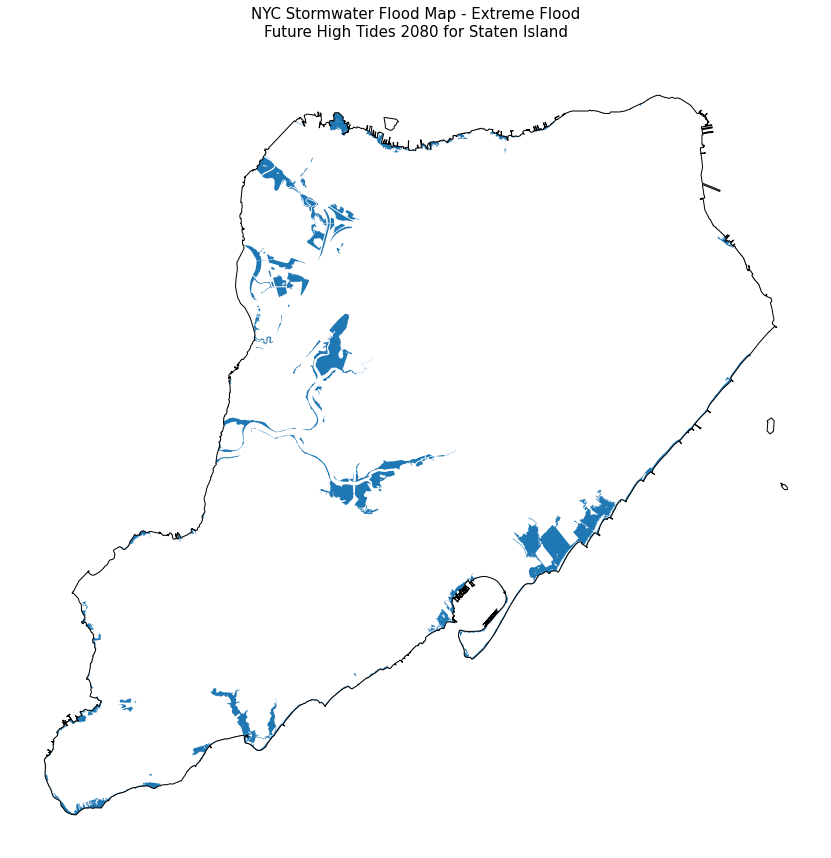

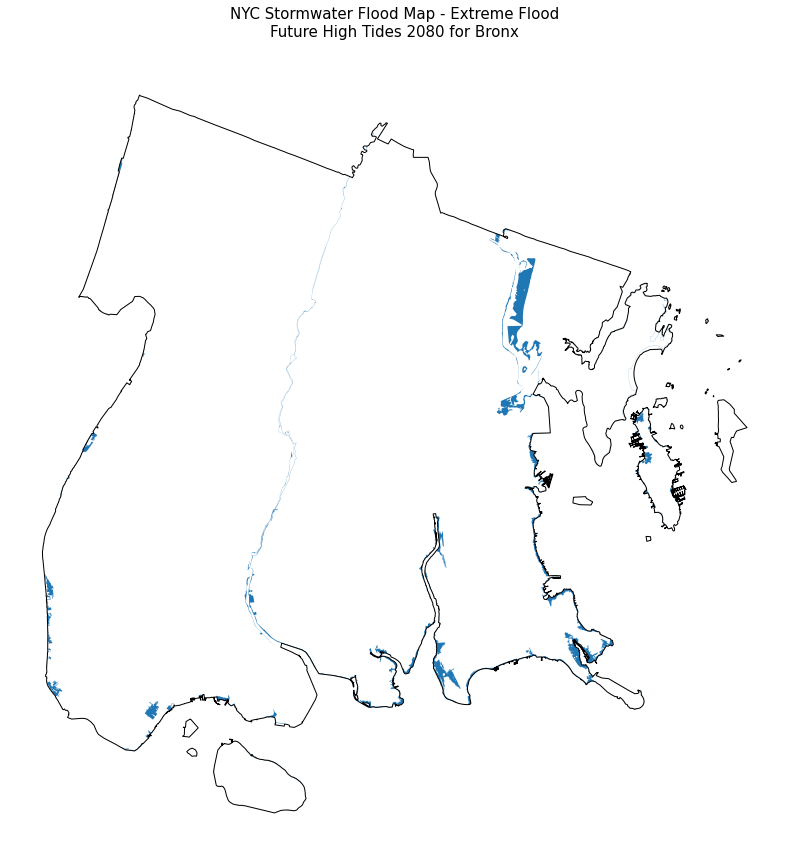

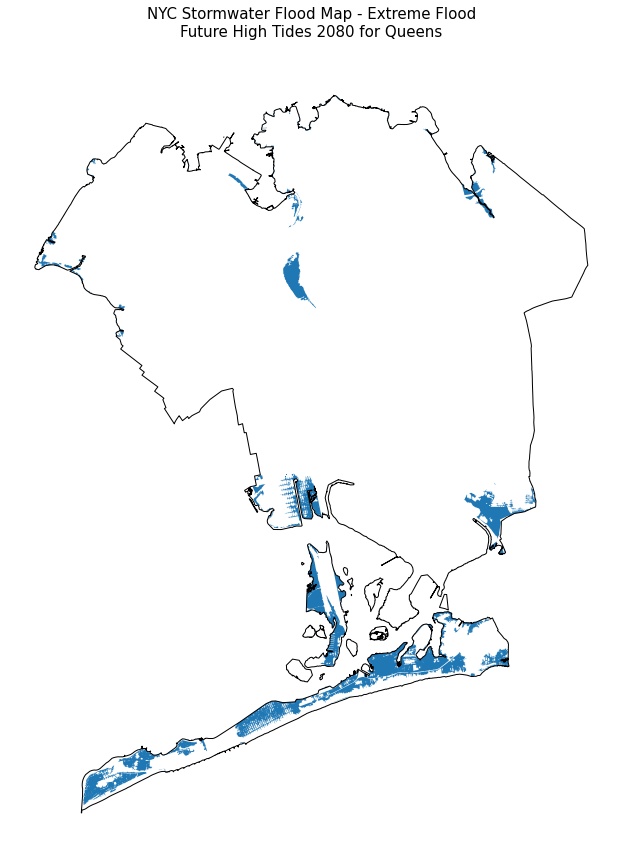

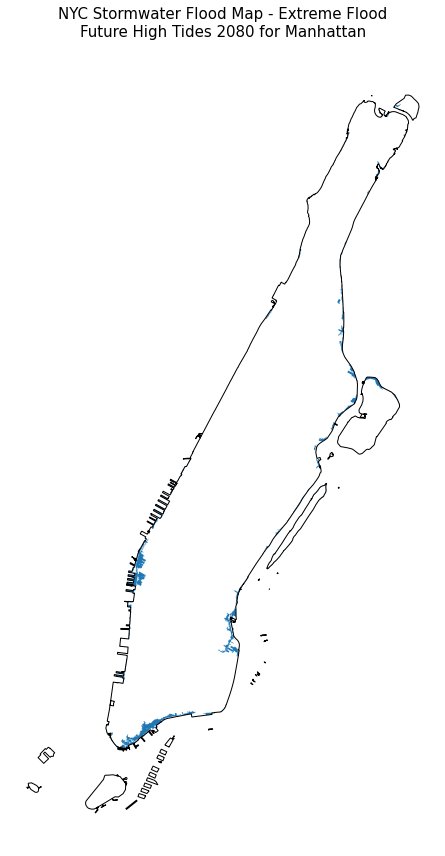

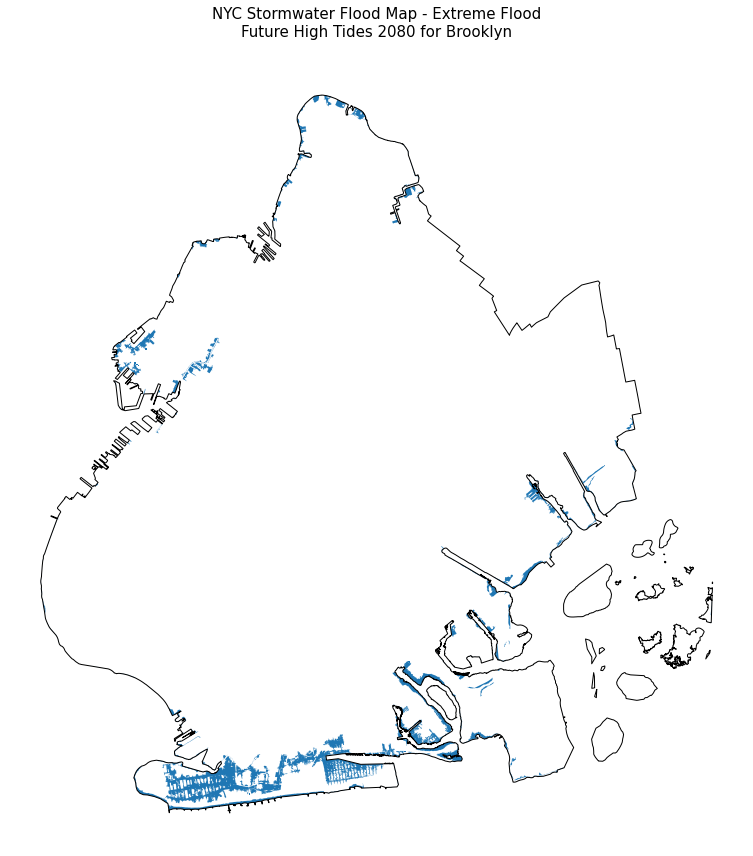

In [17]:
boros = borough_gdf['boro_name'].to_list()
classification = 'Future High Tides 2080'

for boro in boros: 
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    (clipped_gdf
     .loc[
         (clipped_gdf['flood_classification'] == classification)
         & (clipped_gdf['boro'].isin([boro]))]
     .plot(ax=ax)
    )

    (borough_gdf
     .loc[borough_gdf['boro_name'] == boro]
     .plot(ax=ax, facecolor='none', edgecolor='black', zorder=1)
    )

    title = 'NYC Stormwater Flood Map - Extreme Flood\n{} for {}\n'.format(classification, boro)
    plt.axis('off')
    plt.title(title, fontsize=15)   
    plt.tight_layout()

# NYC Neighborhood Tabulation Areas (NTAs)

In [18]:
# importing neighborhood boundaries
path = 'https://data.cityofnewyork.us/api/geospatial/9nt8-h7nd?accessType=DOWNLOAD&method=export&format=Shapefile'
nta_gdf = gpd.read_file(path)

# preview data
print('shape of data: {}'.format(nta_gdf.shape))
nta_gdf.head()

shape of data: (262, 12)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry
0,1.0,Manhattan,061,MN6491,Central Park,CntrlPk,9,MN64,MN64 Central Park (JIA 64 Equivalent),32721.097429,3.831238e+07,"POLYGON ((-73.95246 40.79824, -73.95237 40.798..."
1,1.0,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235570,2.967175e+07,"POLYGON ((-74.00440 40.76267, -74.00220 40.761..."
2,1.0,Manhattan,061,MN0301,Chinatown-Two Bridges,Chntwn,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),16464.371337,1.154263e+07,"POLYGON ((-73.98915 40.71671, -73.98975 40.715..."
3,1.0,Manhattan,061,MN1102,East Harlem (North),EstHrlm_N,0,MN11,MN11 East Harlem (CD 11 Equivalent),28710.999462,2.610451e+07,"MULTIPOLYGON (((-73.92719 40.79735, -73.92735 ..."
4,1.0,Manhattan,061,MN1101,East Harlem (South),EstHrlm_S,0,MN11,MN11 East Harlem (CD 11 Equivalent),18682.264948,1.665394e+07,"POLYGON ((-73.94103 40.79255, -73.93865 40.791..."


In [19]:
# examine crs
nta_gdf.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [20]:
# transform crs
nta_gdf = nta_gdf.to_crs(2263)

nta_gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [21]:
# examine any multipolygons
nta_gdf['geometry'].geom_type.value_counts()

Polygon         228
MultiPolygon     34
dtype: int64

Examine MultiPolygons further.

(905464.7390380852, 1075092.8783935553, 112492.5738036502, 280480.09001459717)

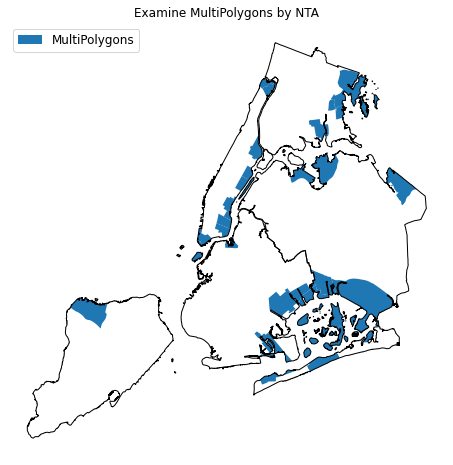

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

(nta_gdf
 .loc[nta_gdf['geometry'].geom_type.isin(['MultiPolygon'])]
 .plot(ax=ax)
)

borough_gdf.plot(ax=ax, color='None')

patches = [mpatches.Patch(label='MultiPolygons')]
plt.legend(handles=patches, loc=2, fontsize=12)

plt.title('Examine MultiPolygons by NTA')
plt.axis('off')

Not perfect for clip or spatial join operations, but we can keep these geometries.

Text(0.5, 1.0, 'NYC Neighborhood Tabulation Areas')

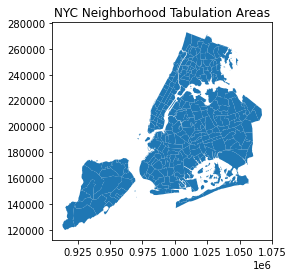

In [23]:
# quick sanity plot of ntas
nta_gdf.plot()
plt.title('NYC Neighborhood Tabulation Areas')

# Clip Flood Polygons by Neighborhood Tabulation Area (NTA)

In [24]:
%%time

ntas = nta_gdf['nta2020'].unique()
lst = []

for nta in ntas:
    
    mask = nta_gdf.loc[nta_gdf['nta2020'] == nta]
    gdf['geometry'] = gdf['geometry'].buffer(0)
    
    clipped = gpd.clip(gdf, mask)
    clipped['nta2020'] = nta
    lst.append(clipped)

clipped_gdf = pd.concat(lst).reset_index(drop=True)
clipped_gdf['Shape_Area'] = clipped_gdf.area
clipped_gdf['Shape_Length'] = clipped_gdf.length

# preview data
print('shape of data: {}'.format(clipped_gdf.shape))
clipped_gdf.head()

shape of data: (14139, 6)
CPU times: user 53min 43s, sys: 25.2 s, total: 54min 9s
Wall time: 1h 3s


,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry,nta2020
0,1,Nuisance Flooding,997.896831,11764.764800,"POLYGON Z ((989502.923 219532.194 0.000, 98951...",MN6491
1,1,Nuisance Flooding,909.683868,10867.391519,"MULTIPOLYGON Z (((994245.122 222327.931 0.000,...",MN6491
2,1,Nuisance Flooding,1419.027108,14476.612669,"MULTIPOLYGON Z (((996378.141 226133.589 0.000,...",MN6491
3,1,Nuisance Flooding,132.105603,579.257681,"POLYGON Z ((998039.417 229133.663 0.000, 99802...",MN6491
4,1,Nuisance Flooding,141.228932,1101.267642,"POLYGON Z ((998182.392 229673.957 0.000, 99817...",MN6491


Brief QA of clipped flood polygons against NTAs.

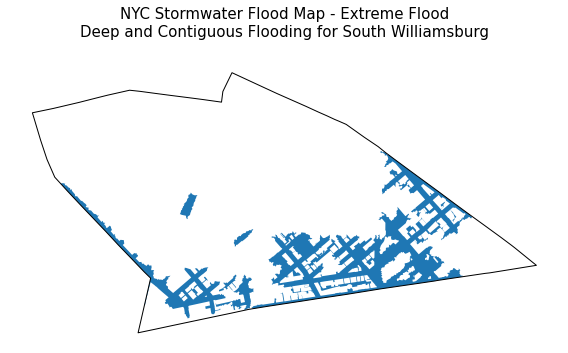

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

classification = 'Deep and Contiguous Flooding'

# south williamsburg, bk
nta_id = 'BK0103'
nta_name = (
    nta_gdf
    .loc[nta_gdf['nta2020'] == nta_id]['ntaname']
    .values[0]
)

(clipped_gdf
 .loc[
     (clipped_gdf['nta2020'] == nta_id)
     & (clipped_gdf['flood_classification'] == classification)]
 .plot(ax=ax)
)

(nta_gdf
 .loc[nta_gdf['nta2020'] == nta_id]
 .plot(ax=ax, color='None')
)

plt.axis('off')
plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
{} for {}\n'.format(classification, nta_name), fontsize=15)   
plt.tight_layout()

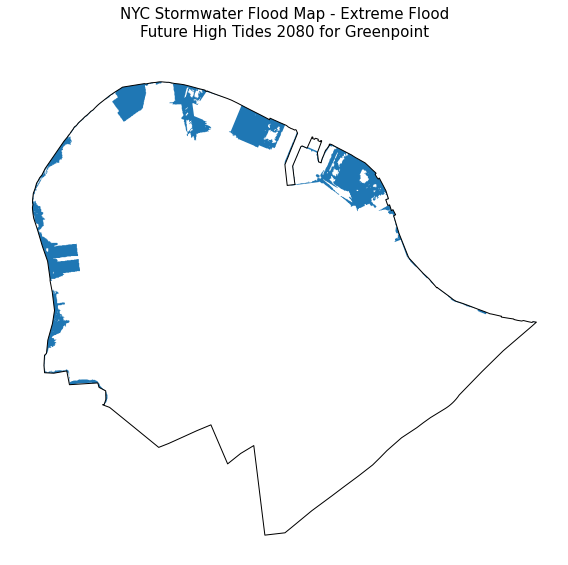

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

classification = 'Future High Tides 2080'

# greenpoint, bk
nta_id = 'BK0101'
nta_name = (
    nta_gdf
    .loc[nta_gdf['nta2020'] == nta_id]['ntaname']
    .values[0]
)

(clipped_gdf
 .loc[
     (clipped_gdf['nta2020'] == nta_id)
     & (clipped_gdf['flood_classification'] == classification)]
 .plot(ax=ax)
)

(nta_gdf
 .loc[nta_gdf['nta2020'] == nta_id]
 .plot(ax=ax, color='None')
)

plt.axis('off')
plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
{} for {}\n'.format(classification, nta_name), fontsize=15)   
plt.tight_layout()

Perform summary stats by NTA.

In [27]:
nta_area = (
    clipped_gdf
    .groupby(by=['nta2020', 'flood_classification'])[['Shape_Area']]
    .sum()
    .reset_index()
    .rename(columns={'Shape_Area':'flooded_area'})
) 

nta_merged = nta_area.merge(
    nta_gdf.loc[:, ['nta2020', 'ntaname', 'shape_area', 'boroname']],
    on='nta2020'
)

nta_merged.head()

,nta2020,flood_classification,flooded_area,ntaname,shape_area,boroname
0,BK0101,Deep and Contiguous Flooding,1.790620e+06,Greenpoint,3.532121e+07,Brooklyn
1,BK0101,Future High Tides 2080,2.038655e+06,Greenpoint,3.532121e+07,Brooklyn
2,BK0101,Nuisance Flooding,1.307740e+06,Greenpoint,3.532121e+07,Brooklyn
3,BK0102,Deep and Contiguous Flooding,1.706097e+06,Williamsburg,2.885436e+07,Brooklyn
4,BK0102,Future High Tides 2080,7.384257e+05,Williamsburg,2.885436e+07,Brooklyn


In [28]:
nta_merged['flooded_area_perc'] = round(nta_merged['flooded_area'] / nta_merged['shape_area'] * 100, 2)
nta_merged['ntaname_boro'] = nta_merged['ntaname'] + ', ' + nta_merged['boroname']

nta_merged.head()

,nta2020,flood_classification,flooded_area,ntaname,shape_area,boroname,flooded_area_perc,ntaname_boro
0,BK0101,Deep and Contiguous Flooding,1.790620e+06,Greenpoint,3.532121e+07,Brooklyn,5.07,"Greenpoint, Brooklyn"
1,BK0101,Future High Tides 2080,2.038655e+06,Greenpoint,3.532121e+07,Brooklyn,5.77,"Greenpoint, Brooklyn"
2,BK0101,Nuisance Flooding,1.307740e+06,Greenpoint,3.532121e+07,Brooklyn,3.70,"Greenpoint, Brooklyn"
3,BK0102,Deep and Contiguous Flooding,1.706097e+06,Williamsburg,2.885436e+07,Brooklyn,5.91,"Williamsburg, Brooklyn"
4,BK0102,Future High Tides 2080,7.384257e+05,Williamsburg,2.885436e+07,Brooklyn,2.56,"Williamsburg, Brooklyn"


In [29]:
cols = [
    'nta2020', 'shape_area',
    'flood_classification', 'flooded_area', 'flooded_area_perc',
    'ntaname', 'boroname',  'ntaname_boro'
]

nta_merged = nta_merged.loc[:, cols]

nta_merged.head()

,nta2020,shape_area,flood_classification,flooded_area,flooded_area_perc,ntaname,boroname,ntaname_boro
0,BK0101,3.532121e+07,Deep and Contiguous Flooding,1.790620e+06,5.07,Greenpoint,Brooklyn,"Greenpoint, Brooklyn"
1,BK0101,3.532121e+07,Future High Tides 2080,2.038655e+06,5.77,Greenpoint,Brooklyn,"Greenpoint, Brooklyn"
2,BK0101,3.532121e+07,Nuisance Flooding,1.307740e+06,3.70,Greenpoint,Brooklyn,"Greenpoint, Brooklyn"
3,BK0102,2.885436e+07,Deep and Contiguous Flooding,1.706097e+06,5.91,Williamsburg,Brooklyn,"Williamsburg, Brooklyn"
4,BK0102,2.885436e+07,Future High Tides 2080,7.384257e+05,2.56,Williamsburg,Brooklyn,"Williamsburg, Brooklyn"


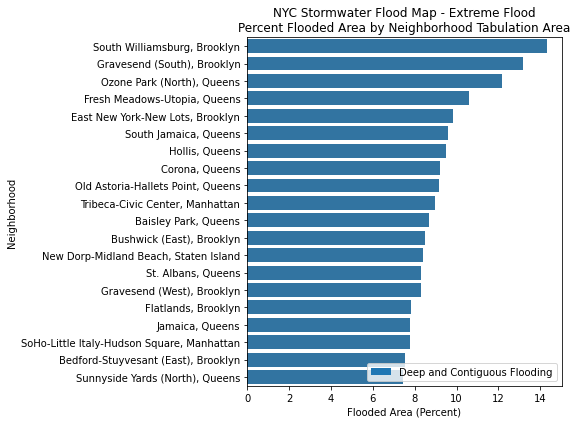

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

data = (
    nta_merged
    .loc[nta_merged['flood_classification'].isin(['Deep and Contiguous Flooding'])]
    .reset_index(drop=True)
    .sort_values(by='flooded_area_perc' ,ascending=False)
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flooded_area_perc', 
    color='C0',
    ax=ax
)

patches = [mpatches.Patch(label='Deep and Contiguous Flooding')]
plt.legend(handles=patches, loc=4, fontsize=10)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Percent Flooded Area by Neighborhood Tabulation Area', fontsize=12)
plt.xlabel('Flooded Area (Percent)')
plt.ylabel('Neighborhood')
plt.tight_layout()

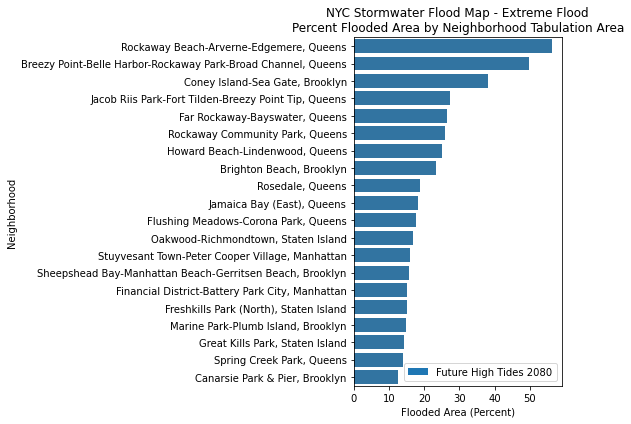

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

data = (
    nta_merged
    .loc[nta_merged['flood_classification'].isin(['Future High Tides 2080'])]
    .reset_index(drop=True)
    .sort_values(by='flooded_area_perc', ascending=False)
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flooded_area_perc', 
    color='C0',
    ax=ax
)

patches = [mpatches.Patch(label='Future High Tides 2080')]
plt.legend(handles=patches, loc=4, fontsize=10)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Percent Flooded Area by Neighborhood Tabulation Area', fontsize=12)
plt.xlabel('Flooded Area (Percent)')
plt.ylabel('Neighborhood')
plt.tight_layout()

In [32]:
# save data to file
nta_merged.to_csv('data/nta-hazard.csv', index=False)

# NYC Building Footprints

In [33]:
%%time

# read in building footprints
path = 'https://data.cityofnewyork.us/api/geospatial/nqwf-w8eh?method=export&format=Original'
building_gdf = gpd.read_file(path)

# sanity check
print('shape of data: {}'.format(building_gdf.shape))
building_gdf.head()

shape of data: (1084024, 16)
CPU times: user 1min 48s, sys: 10.7 s, total: 1min 59s
Wall time: 2min 13s


,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID,geometry
0,None,3170958,1925.0,2017-08-22,Constructed,96807,29.749853,2100,40.0,0.0,0.0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F},"POLYGON ((993508.772 167345.645, 993452.492 16..."
1,None,5028452,1965.0,2017-08-22,Constructed,326368,22.630000,2100,39.0,0.0,0.0,5012640036,5012640036,Photogramm,{F5F8CDA5-69E2-46F8-8F69-BA95C025B520},"POLYGON ((937651.670 172257.299, 937650.883 17..."
2,None,5078368,1970.0,2017-08-22,Constructed,746627,35.760000,2100,51.0,0.0,0.0,5060190091,5060190091,Photogramm,{9F644794-F72C-4582-9E5E-B337E2B97068},"POLYGON ((930033.534 141941.580, 930007.810 14..."
3,None,3245111,1928.0,2017-08-22,Constructed,786626,37.500000,2100,6.0,0.0,0.0,3086910048,3086910048,Photogramm,{F916B22D-E25B-44AE-9FA9-2A51191B9CDF},"POLYGON ((995046.423 149655.549, 995041.868 14..."
4,None,4161096,1950.0,2017-08-22,Constructed,746409,18.015113,2100,93.0,0.0,0.0,4075020005,4075020005,Photogramm,{525F2C24-616B-4F29-98A3-8FEA5D4B1A7D},"POLYGON ((1052344.058 214771.630, 1052356.451 ..."


In [34]:
# transform crs
building_gdf = building_gdf.to_crs(2263)
building_gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

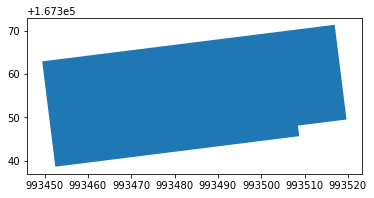

In [35]:
# confirming footprints are polygons
s = building_gdf.geom_type == 'Polygon'
assert s.all()

# sanity check
building_gdf.head(1).plot()

We'll have two geometries: polgygons for spatial joins against flood hazards, and centroids to assign neighborhoods.

In [36]:
# add centroid column and copy the polygon geometry column
building_gdf['centroid'] = building_gdf.centroid
building_gdf['geom'] = building_gdf['geometry']

# preview data
building_gdf.head()

,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID,geometry,centroid,geom
0,None,3170958,1925.0,2017-08-22,Constructed,96807,29.749853,2100,40.0,0.0,0.0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F},"POLYGON ((993508.772 167345.645, 993452.492 16...",POINT (993484.219 167355.101),"POLYGON ((993508.772 167345.645, 993452.492 16..."
1,None,5028452,1965.0,2017-08-22,Constructed,326368,22.630000,2100,39.0,0.0,0.0,5012640036,5012640036,Photogramm,{F5F8CDA5-69E2-46F8-8F69-BA95C025B520},"POLYGON ((937651.670 172257.299, 937650.883 17...",POINT (937638.060 172243.420),"POLYGON ((937651.670 172257.299, 937650.883 17..."
2,None,5078368,1970.0,2017-08-22,Constructed,746627,35.760000,2100,51.0,0.0,0.0,5060190091,5060190091,Photogramm,{9F644794-F72C-4582-9E5E-B337E2B97068},"POLYGON ((930033.534 141941.580, 930007.810 14...",POINT (930013.874 141940.012),"POLYGON ((930033.534 141941.580, 930007.810 14..."
3,None,3245111,1928.0,2017-08-22,Constructed,786626,37.500000,2100,6.0,0.0,0.0,3086910048,3086910048,Photogramm,{F916B22D-E25B-44AE-9FA9-2A51191B9CDF},"POLYGON ((995046.423 149655.549, 995041.868 14...",POINT (995037.705 149646.997),"POLYGON ((995046.423 149655.549, 995041.868 14..."
4,None,4161096,1950.0,2017-08-22,Constructed,746409,18.015113,2100,93.0,0.0,0.0,4075020005,4075020005,Photogramm,{525F2C24-616B-4F29-98A3-8FEA5D4B1A7D},"POLYGON ((1052344.058 214771.630, 1052356.451 ...",POINT (1052324.886 214746.650),"POLYGON ((1052344.058 214771.630, 1052356.451 ..."


For the building-level analysis, I wanted to remove neighborhoods with small number of properties, as these could influence and skew the % of neighborhood statistic. To start, let's remove cemeteries.

In [37]:
# drop cemetery areas from building counts analysis
print('rows: {}'.format(nta_gdf.shape[0]))

cemeteries = 'Cemetery|Cemeteries'

nta_gdf = (
    nta_gdf
    .loc[~nta_gdf['ntaname'].str.contains(cemeteries)]
    .reset_index(drop=True)
)

print('rows by dropping cemetary areas: {}'.format(len(nta_gdf)))
nta_gdf.head()

rows: 262
rows by dropping cemetary areas: 248


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry
0,1.0,Manhattan,061,MN6491,Central Park,CntrlPk,9,MN64,MN64 Central Park (JIA 64 Equivalent),32721.097429,3.831238e+07,"POLYGON ((997412.248 230101.816, 997436.269 23..."
1,1.0,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235570,2.967175e+07,"POLYGON ((983031.177 217138.506, 983640.320 21..."
2,1.0,Manhattan,061,MN0301,Chinatown-Two Bridges,Chntwn,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),16464.371337,1.154263e+07,"POLYGON ((987256.457 200392.989, 987090.306 19..."
3,1.0,Manhattan,061,MN1102,East Harlem (North),EstHrlm_N,0,MN11,MN11 East Harlem (CD 11 Equivalent),28710.999462,2.610451e+07,"MULTIPOLYGON (((1004410.678 229781.419, 100436..."
4,1.0,Manhattan,061,MN1101,East Harlem (South),EstHrlm_S,0,MN11,MN11 East Harlem (CD 11 Equivalent),18682.264948,1.665394e+07,"POLYGON ((1000577.175 228028.553, 1001238.138 ..."


In [38]:
%%time

# spatial join neighborhood data to building footprints
building_nta = gpd.sjoin(
    building_gdf.set_geometry(building_gdf['centroid']),
    nta_gdf.loc[:, ['nta2020', 'geometry']],
    how="left"
)

# set our geometry back on polygon geometry
building_nta = (
    building_nta
    .set_geometry(building_nta['geom'])
    .drop(columns=['index_right'])
)

# sanity check
print('shape of data: {}'.format(building_nta.shape))
building_nta.head()

shape of data: (1084024, 19)
CPU times: user 1min 30s, sys: 3.29 s, total: 1min 33s
Wall time: 1min 35s


,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID,geometry,centroid,geom,nta2020
0,None,3170958,1925.0,2017-08-22,Constructed,96807,29.749853,2100,40.0,0.0,0.0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F},"POLYGON ((993508.772 167345.645, 993452.492 16...",POINT (993484.219 167355.101),"POLYGON ((993508.772 167345.645, 993452.492 16...",BK1204
1,None,5028452,1965.0,2017-08-22,Constructed,326368,22.630000,2100,39.0,0.0,0.0,5012640036,5012640036,Photogramm,{F5F8CDA5-69E2-46F8-8F69-BA95C025B520},"POLYGON ((937651.670 172257.299, 937650.883 17...",POINT (937638.060 172243.420),"POLYGON ((937651.670 172257.299, 937650.883 17...",SI0107
2,None,5078368,1970.0,2017-08-22,Constructed,746627,35.760000,2100,51.0,0.0,0.0,5060190091,5060190091,Photogramm,{9F644794-F72C-4582-9E5E-B337E2B97068},"POLYGON ((930033.534 141941.580, 930007.810 14...",POINT (930013.874 141940.012),"POLYGON ((930033.534 141941.580, 930007.810 14...",SI0303
3,None,3245111,1928.0,2017-08-22,Constructed,786626,37.500000,2100,6.0,0.0,0.0,3086910048,3086910048,Photogramm,{F916B22D-E25B-44AE-9FA9-2A51191B9CDF},"POLYGON ((995046.423 149655.549, 995041.868 14...",POINT (995037.705 149646.997),"POLYGON ((995046.423 149655.549, 995041.868 14...",BK1303
4,None,4161096,1950.0,2017-08-22,Constructed,746409,18.015113,2100,93.0,0.0,0.0,4075020005,4075020005,Photogramm,{525F2C24-616B-4F29-98A3-8FEA5D4B1A7D},"POLYGON ((1052344.058 214771.630, 1052356.451 ...",POINT (1052324.886 214746.650),"POLYGON ((1052344.058 214771.630, 1052356.451 ...",QN1102


Examine small NTAs.

In [39]:
small_ntas = (
    building_nta
    .merge(nta_gdf, on='nta2020')
    .groupby(by=['nta2020', 'ntaname'])['DOITT_ID']
    .count()
    .rename('count')
    .reset_index()
)

small_ntas.head()

,nta2020,ntaname,count
0,BK0101,Greenpoint,5162
1,BK0102,Williamsburg,3653
2,BK0103,South Williamsburg,2284
3,BK0104,East Williamsburg,4972
4,BK0201,Brooklyn Heights,1489


In [40]:
(small_ntas
 .sort_values(by='count')
 .head(40)
)

,nta2020,ntaname,count
25,BK0891,Lincoln Terrace Park,2
42,BK1391,Calvert Vaux Park,3
60,BK1893,Canarsie Park & Pier,4
94,BX0991,Soundview Park,5
63,BK5693,Shirley Chisholm State Park,6
156,QN0191,Astoria Park,6
77,BX0492,Claremont Park,7
216,QN1491,Rockaway Community Park,7
180,QN0791,Kissena Park,7
59,BK1892,McGuire Fields,8


Removing NTAs of less than 80 buildings in this analysis.

In [41]:
# retrieve list of ntas to keep
ntas = (
    small_ntas
    .loc[small_ntas['count'] >= 80, 'nta2020']
    .values
)

print('number of ntas to keep: {}'.format(len(ntas)))

number of ntas to keep: 213


In [42]:
print('rows: {}'.format(building_nta.shape[0]))

building_nta = (
    building_nta
    .loc[building_nta['nta2020'].isin(ntas)]
    .reset_index(drop=True)
)

print('new rows: {}'.format(building_nta.shape[0]))
building_nta.head()

rows: 1084024
new rows: 1082998


,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID,geometry,centroid,geom,nta2020
0,None,3170958,1925.0,2017-08-22,Constructed,96807,29.749853,2100,40.0,0.0,0.0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F},"POLYGON ((993508.772 167345.645, 993452.492 16...",POINT (993484.219 167355.101),"POLYGON ((993508.772 167345.645, 993452.492 16...",BK1204
1,None,5028452,1965.0,2017-08-22,Constructed,326368,22.630000,2100,39.0,0.0,0.0,5012640036,5012640036,Photogramm,{F5F8CDA5-69E2-46F8-8F69-BA95C025B520},"POLYGON ((937651.670 172257.299, 937650.883 17...",POINT (937638.060 172243.420),"POLYGON ((937651.670 172257.299, 937650.883 17...",SI0107
2,None,5078368,1970.0,2017-08-22,Constructed,746627,35.760000,2100,51.0,0.0,0.0,5060190091,5060190091,Photogramm,{9F644794-F72C-4582-9E5E-B337E2B97068},"POLYGON ((930033.534 141941.580, 930007.810 14...",POINT (930013.874 141940.012),"POLYGON ((930033.534 141941.580, 930007.810 14...",SI0303
3,None,3245111,1928.0,2017-08-22,Constructed,786626,37.500000,2100,6.0,0.0,0.0,3086910048,3086910048,Photogramm,{F916B22D-E25B-44AE-9FA9-2A51191B9CDF},"POLYGON ((995046.423 149655.549, 995041.868 14...",POINT (995037.705 149646.997),"POLYGON ((995046.423 149655.549, 995041.868 14...",BK1303
4,None,4161096,1950.0,2017-08-22,Constructed,746409,18.015113,2100,93.0,0.0,0.0,4075020005,4075020005,Photogramm,{525F2C24-616B-4F29-98A3-8FEA5D4B1A7D},"POLYGON ((1052344.058 214771.630, 1052356.451 ...",POINT (1052324.886 214746.650),"POLYGON ((1052344.058 214771.630, 1052356.451 ...",QN1102


In [43]:
%%time

# spatial join stormwater flood polygons to building footprints
building_hazards = gpd.sjoin(
    building_nta,
    gdf,
    how="inner"
)

# sanity check
print('shape of data: {}'.format(building_hazards.shape))
building_hazards.head()

shape of data: (155598, 24)
CPU times: user 4min 55s, sys: 12 s, total: 5min 7s
Wall time: 5min 11s


,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,...,GLOBALID,geometry,centroid,geom,nta2020,index_right,Flooding_Category,flood_classification,Shape_Length,Shape_Area
7,None,5053676,1950.0,2017-08-22,Constructed,105644,16.08,2100,8.0,0.0,...,{12A0A3E5-04CF-4188-941E-D77CE8728E4E},"POLYGON ((955611.494 148636.721, 955598.900 14...",POINT (955597.497 148641.656),"POLYGON ((955611.494 148636.721, 955598.900 14...",SI0202,8270,2,Deep and Contiguous Flooding,26758.062961,874235.998201
860,None,5161391,1920.0,2017-08-17,Constructed,1227099,10.15,5110,7.0,0.0,...,{A546A2E4-8C15-4028-8E54-36D43FFEE212},"POLYGON ((955711.660 148840.270, 955704.403 14...",POINT (955699.492 148841.391),"POLYGON ((955711.660 148840.270, 955704.403 14...",SI0202,8270,2,Deep and Contiguous Flooding,26758.062961,874235.998201
4596,None,5150199,1998.0,2017-08-22,Constructed,913014,26.32,2100,9.0,0.0,...,{C6FFF6CF-5E1E-4E53-8715-98DA648AE196},"POLYGON ((955764.171 149295.246, 955736.341 14...",POINT (955743.898 149279.578),"POLYGON ((955764.171 149295.246, 955736.341 14...",SI0202,8270,2,Deep and Contiguous Flooding,26758.062961,874235.998201
6952,None,5053606,1920.0,2017-08-22,Constructed,475506,19.71,2100,8.0,0.0,...,{53D6FE14-F888-4321-A779-68874B5F61AF},"POLYGON ((955682.214 148810.281, 955656.164 14...",POINT (955660.142 148799.136),"POLYGON ((955682.214 148810.281, 955656.164 14...",SI0202,8270,2,Deep and Contiguous Flooding,26758.062961,874235.998201
11145,None,5053612,1960.0,2017-08-22,Constructed,171931,25.46,2100,8.0,0.0,...,{82E11669-AD9F-49A7-B7DE-8B8A27DFDC5E},"POLYGON ((955890.341 149051.807, 955880.490 14...",POINT (955867.285 149057.838),"POLYGON ((955890.341 149051.807, 955880.490 14...",SI0202,8270,2,Deep and Contiguous Flooding,26758.062961,874235.998201


In [44]:
# group count of flooded buildings per neighborhood and flood classification
building_hazards = (
    building_hazards
    .groupby(by=['nta2020', 'flood_classification'])['DOITT_ID']
    .count()
    .sort_values(ascending=False)
    .rename('flooded_count')
    .reset_index()
)

# sanity check
building_hazards.head()

,nta2020,flood_classification,flooded_count
0,QN1403,Future High Tides 2080,6124
1,QN1402,Future High Tides 2080,3406
2,QN1205,Deep and Contiguous Flooding,2304
3,QN1003,Future High Tides 2080,2064
4,BK1503,Future High Tides 2080,1857


In [45]:
# group count of buildings per neighborhood
building_nta = (
    building_nta
    .groupby(by=['nta2020'])['DOITT_ID']
    .count()
    .sort_values(ascending=False)
    .rename('building_count')
    .reset_index()
)

# sanity check
building_nta.head()

,nta2020,building_count
0,QN1001,23685
1,QN1303,19817
2,QN1205,18814
3,SI0302,17562
4,BK1801,15907


In [46]:
# merge both dataframes into one
merged_df = building_nta.merge(
    building_hazards,
    on='nta2020',
    how='left'
)

merged_df['flooded_count'] = merged_df['flooded_count'].fillna(0).astype(int)
merged_df['flooded_perc'] = merged_df['flooded_count'] / merged_df['building_count'] * 100
merged_df['flooded_perc'] = merged_df['flooded_perc'].fillna(0).round(2)

# preview data
merged_df.head()

,nta2020,building_count,flood_classification,flooded_count,flooded_perc
0,QN1001,23685,Deep and Contiguous Flooding,1812,7.65
1,QN1001,23685,Nuisance Flooding,1285,5.43
2,QN1303,19817,Nuisance Flooding,1691,8.53
3,QN1303,19817,Deep and Contiguous Flooding,1231,6.21
4,QN1205,18814,Deep and Contiguous Flooding,2304,12.25


In [47]:
# retrieve additional columns from nta dataframe
merged_df = merged_df.merge(
    nta_gdf.loc[:, ['nta2020', 'ntaname', 'boroname']],
    how='left',
    on='nta2020'
)

merged_df['ntaname_boro'] = merged_df['ntaname'] + ', ' + merged_df['boroname']

# preview data
merged_df.head()

,nta2020,building_count,flood_classification,flooded_count,flooded_perc,ntaname,boroname,ntaname_boro
0,QN1001,23685,Deep and Contiguous Flooding,1812,7.65,South Ozone Park,Queens,"South Ozone Park, Queens"
1,QN1001,23685,Nuisance Flooding,1285,5.43,South Ozone Park,Queens,"South Ozone Park, Queens"
2,QN1303,19817,Nuisance Flooding,1691,8.53,Queens Village,Queens,"Queens Village, Queens"
3,QN1303,19817,Deep and Contiguous Flooding,1231,6.21,Queens Village,Queens,"Queens Village, Queens"
4,QN1205,18814,Deep and Contiguous Flooding,2304,12.25,St. Albans,Queens,"St. Albans, Queens"


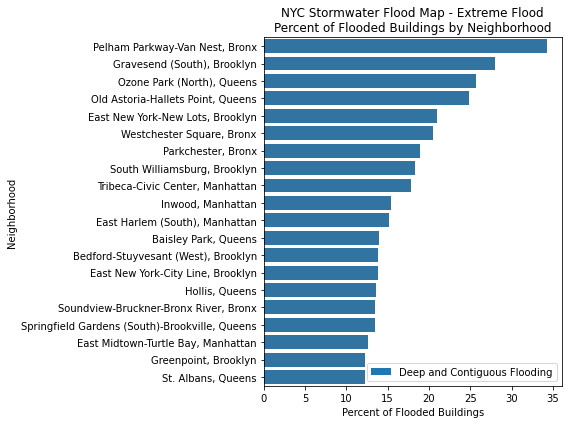

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

label = 'Deep and Contiguous Flooding'

data = (
    merged_df
    .loc[merged_df['flood_classification'].isin([label])]
    .reset_index(drop=True)
    .sort_values(by='flooded_perc' ,ascending=False)
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flooded_perc', 
    color='C0',
    ax=ax
)

patches = [mpatches.Patch(label=label)]
plt.legend(handles=patches, loc=4, fontsize=10)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Percent of Flooded Buildings by Neighborhood', fontsize=12)
plt.xlabel('Percent of Flooded Buildings')
plt.ylabel('Neighborhood')
plt.tight_layout()

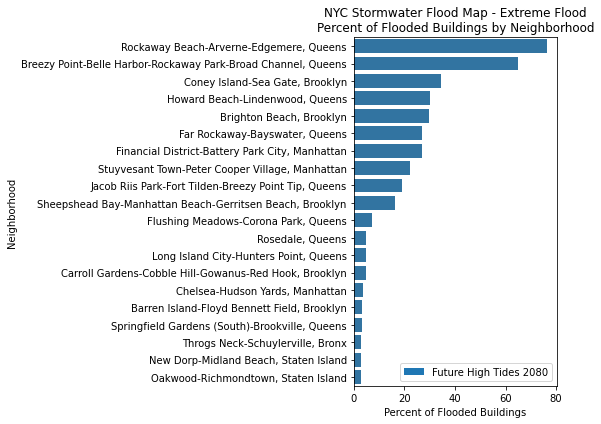

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))

label = 'Future High Tides 2080'

data = (
    merged_df
    .loc[merged_df['flood_classification'].isin([label])]
    .reset_index(drop=True)
    .sort_values(by='flooded_perc' ,ascending=False)
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flooded_perc', 
    color='C0',
    ax=ax
)

patches = [mpatches.Patch(label=label)]
plt.legend(handles=patches, loc=4, fontsize=10)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Percent of Flooded Buildings by Neighborhood', fontsize=12)
plt.xlabel('Percent of Flooded Buildings')
plt.ylabel('Neighborhood')
plt.tight_layout()

In [50]:
# save data to file
merged_df.to_csv('data/buildings-hazard.csv', index=False)